In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from collections import defaultdict, Counter
import os

In [68]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
weather = pd.read_csv('weather.csv')
weather.head(10)

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,0448,1849,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,-,-,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,0447,1850,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,-,-,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,0446,1851,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9
5,2,2007-05-03,67,48,58,M,40,50,7,0,-,-,HZ,M,M,M,0.00,29.46,30.12,12.9,6,13.2
6,1,2007-05-04,66,49,58,4,41,50,7,0,0444,1852,RA,0,M,0.0,T,29.31,30.05,10.4,8,10.8
7,2,2007-05-04,78,51,M,M,42,50,M,M,-,-,,M,M,M,0.00,29.36,30.04,10.1,7,10.4
8,1,2007-05-05,66,53,60,5,38,49,5,0,0443,1853,,0,M,0.0,T,29.40,30.10,11.7,7,12.0
9,2,2007-05-05,66,54,60,M,39,50,5,0,-,-,,M,M,M,T,29.46,30.09,11.2,7,11.5


In [4]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   object 
 5   Depart       2944 non-null   object 
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   object 
 8   Heat         2944 non-null   object 
 9   Cool         2944 non-null   object 
 10  Sunrise      2944 non-null   object 
 11  Sunset       2944 non-null   object 
 12  CodeSum      2944 non-null   object 
 13  Depth        2944 non-null   object 
 14  Water1       2944 non-null   object 
 15  SnowFall     2944 non-null   object 
 16  PrecipTotal  2944 non-null   object 
 17  StnPressure  2944 non-null   object 
 18  SeaLevel     2944 non-null   object 
 19  Result

Lots of columns are object type, so we first strip all the string values for convenience

In [5]:
for col in weather.columns:
    if weather[col].dtype=='object':
        weather[col] = weather[col].str.strip()

In [6]:
weather.shape

(2944, 22)

We have lots of missing values. We have two stations, for some of the missing values, we can use the data from one station
to infer the corresponding data in the other station. Also, for many columns, missing data are denoted by 'M' or '-' or the empty string. For some columns, the letter 'T' denotes certain phenomena is observed but the amount is so small such that it cannot be measured using equipments, so for those we will fill it with zero.

In [7]:
mask = np.logical_or((weather.Heat=='M'), (weather.Cool=='M'))
weather.loc[mask, ['Heat', 'Cool']].head(30)

,Heat,Cool
7,M,M
505,M,M
675,M,M
1637,M,M
2067,M,M
2211,M,M
2501,M,M
2511,M,M
2525,M,M
2579,M,M


For Heat and Cool, if one is missing, the other one is also missing, moreover only midway station data are missing, so we can fill it in with ohare data

In [8]:
weather['SnowFall'].value_counts().sort_values(ascending=False)

M      1472
0.0    1459
T        12
0.1       1
Name: SnowFall, dtype: int64

In [9]:
(weather['Station'].values[weather.SnowFall=='M']==2).sum()/(weather.SnowFall.values=='M').sum()

1.0

This shows that for SnowFall, only the midway data are missing, we can consider fill it with ohare data

In [10]:
weather['ResultDir'].describe()

count    2944.000000
mean       17.494905
std        10.063609
min         1.000000
25%         7.000000
50%        19.000000
75%        25.000000
max        36.000000
Name: ResultDir, dtype: float64

We shall rename some columns so that the meaning of the names make more sense

In [11]:
col_rename = {'CodeSum':'weather_phenomena', 'Depth':'Snow', 'Water1':'water_equiv', 'PrecipTotal':'water_equiv_snowfall',
'StnPressure':'station_pressure', 'SeaLevel':'sealevel_pressure', 'ResultSpeed':'wind_speed', 'ResultDir':'wind_direction',
'AvgSpeed':'avg_wind_speed'}

In [12]:
weather.rename(columns=col_rename, inplace=True)

In [13]:
weather.dtypes

Station                   int64
Date                     object
Tmax                      int64
Tmin                      int64
Tavg                     object
Depart                   object
DewPoint                  int64
WetBulb                  object
Heat                     object
Cool                     object
Sunrise                  object
Sunset                   object
weather_phenomena        object
Snow                     object
water_equiv              object
SnowFall                 object
water_equiv_snowfall     object
station_pressure         object
sealevel_pressure        object
wind_speed              float64
wind_direction            int64
avg_wind_speed           object
dtype: object

get datetime for convenience later

In [14]:
datetime = pd.to_datetime(weather['Date'])

weather['datetime'] = datetime
weather['year'] = datetime.dt.year
weather['month'] = datetime.dt.month
weather['day'] = datetime.dt.day

weather.drop(columns = ['Date'], inplace=True)

In [15]:
weather['Sunrise'].replace('-', np.nan, inplace=True)
weather['Sunset'].replace('-', np.nan, inplace=True)

In [16]:
weather.head(10)

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,weather_phenomena,Snow,water_equiv,SnowFall,water_equiv_snowfall,station_pressure,sealevel_pressure,wind_speed,wind_direction,avg_wind_speed,datetime,year,month,day
0,1,83,50,67,14,51,56,0,2,0448,1849,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2,2007-05-01,2007,5,1
1,2,84,52,68,M,51,57,0,3,NaN,NaN,,M,M,M,0.00,29.18,29.82,2.7,25,9.6,2007-05-01,2007,5,1
2,1,59,42,51,-3,42,47,14,0,0447,1850,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4,2007-05-02,2007,5,2
3,2,60,43,52,M,42,47,13,0,NaN,NaN,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4,2007-05-02,2007,5,2
4,1,66,46,56,2,40,48,9,0,0446,1851,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9,2007-05-03,2007,5,3
5,2,67,48,58,M,40,50,7,0,NaN,NaN,HZ,M,M,M,0.00,29.46,30.12,12.9,6,13.2,2007-05-03,2007,5,3
6,1,66,49,58,4,41,50,7,0,0444,1852,RA,0,M,0.0,T,29.31,30.05,10.4,8,10.8,2007-05-04,2007,5,4
7,2,78,51,M,M,42,50,M,M,NaN,NaN,,M,M,M,0.00,29.36,30.04,10.1,7,10.4,2007-05-04,2007,5,4
8,1,66,53,60,5,38,49,5,0,0443,1853,,0,M,0.0,T,29.40,30.10,11.7,7,12.0,2007-05-05,2007,5,5
9,2,66,54,60,M,39,50,5,0,NaN,NaN,,M,M,M,T,29.46,30.09,11.2,7,11.5,2007-05-05,2007,5,5


Sun rise and sun set time in Ohare and midway should be about the same, so we use one to fill the other.

In [17]:
weather['Sunrise'].fillna(method='ffill', inplace=True)
weather['Sunset'].fillna(method='ffill', inplace=True)

In [18]:
weather.head(10)

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,weather_phenomena,Snow,water_equiv,SnowFall,water_equiv_snowfall,station_pressure,sealevel_pressure,wind_speed,wind_direction,avg_wind_speed,datetime,year,month,day
0,1,83,50,67,14,51,56,0,2,0448,1849,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2,2007-05-01,2007,5,1
1,2,84,52,68,M,51,57,0,3,0448,1849,,M,M,M,0.00,29.18,29.82,2.7,25,9.6,2007-05-01,2007,5,1
2,1,59,42,51,-3,42,47,14,0,0447,1850,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4,2007-05-02,2007,5,2
3,2,60,43,52,M,42,47,13,0,0447,1850,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4,2007-05-02,2007,5,2
4,1,66,46,56,2,40,48,9,0,0446,1851,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9,2007-05-03,2007,5,3
5,2,67,48,58,M,40,50,7,0,0446,1851,HZ,M,M,M,0.00,29.46,30.12,12.9,6,13.2,2007-05-03,2007,5,3
6,1,66,49,58,4,41,50,7,0,0444,1852,RA,0,M,0.0,T,29.31,30.05,10.4,8,10.8,2007-05-04,2007,5,4
7,2,78,51,M,M,42,50,M,M,0444,1852,,M,M,M,0.00,29.36,30.04,10.1,7,10.4,2007-05-04,2007,5,4
8,1,66,53,60,5,38,49,5,0,0443,1853,,0,M,0.0,T,29.40,30.10,11.7,7,12.0,2007-05-05,2007,5,5
9,2,66,54,60,M,39,50,5,0,0443,1853,,M,M,M,T,29.46,30.09,11.2,7,11.5,2007-05-05,2007,5,5


In [19]:
weather['water_equiv'].value_counts().sort_values(ascending=False)

M    2944
Name: water_equiv, dtype: int64

all values are missing, consider drop it

In [20]:
weather['Snow'].value_counts().sort_values(ascending=False)

M    1472
0    1472
Name: Snow, dtype: int64

For snow, we can fill midway data use the ohare data, but then the value of this column will be constant. for water_snow, it is also constant, so we should drop those two columns

In [21]:
weather.drop(columns=['Snow', 'water_equiv'], inplace=True)

In [22]:
weather.head(10)

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,weather_phenomena,SnowFall,water_equiv_snowfall,station_pressure,sealevel_pressure,wind_speed,wind_direction,avg_wind_speed,datetime,year,month,day
0,1,83,50,67,14,51,56,0,2,0448,1849,,0.0,0.00,29.10,29.82,1.7,27,9.2,2007-05-01,2007,5,1
1,2,84,52,68,M,51,57,0,3,0448,1849,,M,0.00,29.18,29.82,2.7,25,9.6,2007-05-01,2007,5,1
2,1,59,42,51,-3,42,47,14,0,0447,1850,BR,0.0,0.00,29.38,30.09,13.0,4,13.4,2007-05-02,2007,5,2
3,2,60,43,52,M,42,47,13,0,0447,1850,BR HZ,M,0.00,29.44,30.08,13.3,2,13.4,2007-05-02,2007,5,2
4,1,66,46,56,2,40,48,9,0,0446,1851,,0.0,0.00,29.39,30.12,11.7,7,11.9,2007-05-03,2007,5,3
5,2,67,48,58,M,40,50,7,0,0446,1851,HZ,M,0.00,29.46,30.12,12.9,6,13.2,2007-05-03,2007,5,3
6,1,66,49,58,4,41,50,7,0,0444,1852,RA,0.0,T,29.31,30.05,10.4,8,10.8,2007-05-04,2007,5,4
7,2,78,51,M,M,42,50,M,M,0444,1852,,M,0.00,29.36,30.04,10.1,7,10.4,2007-05-04,2007,5,4
8,1,66,53,60,5,38,49,5,0,0443,1853,,0.0,T,29.40,30.10,11.7,7,12.0,2007-05-05,2007,5,5
9,2,66,54,60,M,39,50,5,0,0443,1853,,M,T,29.46,30.09,11.2,7,11.5,2007-05-05,2007,5,5


In [23]:
weather['SnowFall'].value_counts().sort_values(ascending=False)

M      1472
0.0    1459
T        12
0.1       1
Name: SnowFall, dtype: int64

SnowFall column is also almost of constant value once we fill midway data with ohare data. There does not seem to be much snow. We can verify this by looking at rows where the weather_phenomena contain 'SN'(stands for snow) or 'SG'(stands for snow grains)

In [24]:
mask = (weather['weather_phenomena'].str.find('SN').values>=0)
weather.loc[mask, :]

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,weather_phenomena,SnowFall,water_equiv_snowfall,station_pressure,sealevel_pressure,wind_speed,wind_direction,avg_wind_speed,datetime,year,month,day
725,2,56,36,46,M,34,41,19,0,0617,1654,RA SN,M,0.01,29.17,29.81,17.5,27,18.4,2008-10-26,2008,10,26
727,2,47,34,41,M,28,35,24,0,0618,1653,RA SN,M,T,29.57,30.21,13.4,31,13.9,2008-10-27,2008,10,27
1089,2,49,39,44,M,37,41,21,0,0614,1657,RA DZ SN,M,0.05,29.10,29.74,9.6,26,10.3,2009-10-24,2009,10,24
2559,2,46,32,39,M,27,34,26,0,0613,1658,RA SN,M,T,29.32,30.00,9.2,29,9.2,2013-10-23,2013,10,23
2942,1,47,33,40,-6,25,33,25,0,0623,1647,RA SN,0.1,0.03,29.49,30.20,22.6,34,22.9,2014-10-31,2014,10,31
2943,2,49,34,42,M,29,36,23,0,0623,1647,RA SN BR,M,0.04,29.54,30.20,21.7,34,22.6,2014-10-31,2014,10,31


In [25]:
mask = (weather['weather_phenomena'].str.find('SG').values>=0)
weather.loc[mask, :]

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,weather_phenomena,SnowFall,water_equiv_snowfall,station_pressure,sealevel_pressure,wind_speed,wind_direction,avg_wind_speed,datetime,year,month,day


Using weather_phenomena we verified that there weren't many snowfall weather in the station. furthermore, snowfall column is not very informative, almost a constant column, consider drop it. 

In [26]:
weather['water_equiv_snowfall'].value_counts().sort_values(ascending=False)

0.00    1577
T        318
0.01     127
0.02      63
0.03      46
        ... 
3.64       1
0.62       1
1.88       1
1.82       1
2.17       1
Name: water_equiv_snowfall, Length: 168, dtype: int64

In [27]:
weather['water_equiv_snowfall'][weather['water_equiv_snowfall'].str.strip()=='M']

117    M
119    M
Name: water_equiv_snowfall, dtype: object

water_equiv_snowfall only has two missing value, which are all midway data, so we may fill those with ohare data

In [28]:
weather['water_equiv_snowfall'].replace('M', np.nan, inplace=True)
weather['water_equiv_snowfall'].fillna(method='ffill', inplace=True)

In [29]:
weather.drop(columns=['SnowFall'], inplace=True)

In [30]:
weather.head(10)

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,weather_phenomena,water_equiv_snowfall,station_pressure,sealevel_pressure,wind_speed,wind_direction,avg_wind_speed,datetime,year,month,day
0,1,83,50,67,14,51,56,0,2,0448,1849,,0.00,29.10,29.82,1.7,27,9.2,2007-05-01,2007,5,1
1,2,84,52,68,M,51,57,0,3,0448,1849,,0.00,29.18,29.82,2.7,25,9.6,2007-05-01,2007,5,1
2,1,59,42,51,-3,42,47,14,0,0447,1850,BR,0.00,29.38,30.09,13.0,4,13.4,2007-05-02,2007,5,2
3,2,60,43,52,M,42,47,13,0,0447,1850,BR HZ,0.00,29.44,30.08,13.3,2,13.4,2007-05-02,2007,5,2
4,1,66,46,56,2,40,48,9,0,0446,1851,,0.00,29.39,30.12,11.7,7,11.9,2007-05-03,2007,5,3
5,2,67,48,58,M,40,50,7,0,0446,1851,HZ,0.00,29.46,30.12,12.9,6,13.2,2007-05-03,2007,5,3
6,1,66,49,58,4,41,50,7,0,0444,1852,RA,T,29.31,30.05,10.4,8,10.8,2007-05-04,2007,5,4
7,2,78,51,M,M,42,50,M,M,0444,1852,,0.00,29.36,30.04,10.1,7,10.4,2007-05-04,2007,5,4
8,1,66,53,60,5,38,49,5,0,0443,1853,,T,29.40,30.10,11.7,7,12.0,2007-05-05,2007,5,5
9,2,66,54,60,M,39,50,5,0,0443,1853,,T,29.46,30.09,11.2,7,11.5,2007-05-05,2007,5,5


For weather_phenomena column, we can use a one-hot encoding. That is, for each row, we keep track of all the code for weather phenomena, then for each code, if this row contains that code, it will have value one, otherwise zero. We also need to fill in missing values. If either ohare or midway are missing, we can use one to fill in the other. If both are missing, then it could be that there were no unusual weather phenomena, so we shall fill those with 'MD' which stands for mild

In [31]:
weather['weather_phenomena'].value_counts().sort_values(ascending=False)

                      1609
RA                     296
RA BR                  238
BR                     110
TSRA RA BR              92
                      ... 
FU                       1
RA SN BR                 1
TSRA RA BR HZ VCTS       1
RA DZ SN                 1
TS TSRA RA HZ            1
Name: weather_phenomena, Length: 98, dtype: int64

take a look at all weather code contains a '+' or '-

In [32]:
weather['weather_phenomena'].str.split().apply(lambda x:tuple([s for s in x if len(s)%2==1])).value_counts().sort_values(ascending=False)

()        2917
(FG+,)      27
Name: weather_phenomena, dtype: int64

Look at rows with more than one weather phenomena code

In [33]:
weather['weather_phenomena'].str.split().apply(lambda x:tuple([s for s in x if len(s)%2==0 and len(s)>2])).value_counts().sort_values(ascending=False)

()              2621
(TSRA,)          293
(TSRA, VCTS)      11
(VCTS,)            8
(BCFG,)            4
(VCFG,)            3
(MIFG,)            2
(TSRA, VCFG)       1
(MIFG, BCFG)       1
Name: weather_phenomena, dtype: int64

Next we shall gather all the available weather phenomena code from files, then fill in missing values, then generate one-hot encoding feature for each phenomena

In [34]:
f = open('noaa_weather_qclcd_documentation.txt', 'r')
content = f.readlines()
f.close()
print(content[:10])


['QUALITY CONTROLLED LOCAL CLIMATOLOGICAL DATA \n', '\n', 'Effective January, 2005, flags will be available for most data elements:\n', '\n', 'If data are suspect: \n', 's will appended to the value on the web form \n', 's will be placed in a column following the suspect value in the ASCII form \n', 'If data are flagged as erroneous, it will not be printed. \n', '\n', '**NOTICE OF CHANGE: \n']


In [35]:
weather_code = []
i = 0
while i<len(content):
    if not content[i].split() or content[i].split()[0]!='12':
        i+=1
    else:
        break

while i<len(content):
    if content[i].split():
        if content[i].split()[0]=='12':
            s = content[i].split()[1]
        else:
            s = content[i].split()[0]
        if not s[0].isalpha():
            s = s[1:]
        elif not s[-1].isalpha():
            s = s[:-1]
        weather_code.append(s)
        if s=='VC':
            break
    i+=1        
        

In [36]:
weather_code

['FC',
 'TS',
 'GR',
 'RA',
 'DZ',
 'SN',
 'SG',
 'GS',
 'IC',
 'FG',
 'FG',
 'BR',
 'UP',
 'HZ',
 'FU',
 'VA',
 'DU',
 'DS',
 'PO',
 'SS',
 'PY',
 'SQ',
 'SH',
 'FZ',
 'MI',
 'PR',
 'BC',
 'BL',
 'VC']

for each weather phenomena code, we can also add '+' or '-'

In [37]:
for i in range(0,len(weather_code)):
    code = weather_code[i]
    weather_code.append(code+'+')
    weather_code.append(code+'-')

Also add default value 'MD'

In [38]:
weather_code.append('MD')

To fill nans for weather_phenomena, we use two strategies. First, let's say weather for station 1 is missing but for station 2 is not missing, then we can use station 2's record. If both are missing, fill in 'MD'

In [39]:
def split_str(s, weather_code = weather_code):
    res = set()
    i, j = 0, len(s)-1
    while i<j:
        if not s[i].isalpha():
            if s[i+1:i+3]+s[i] in weather_code:
                res.add(s[i+1:i+3]+s[i])
            i+=3
        else:
            if s[i:i+2] in weather_code:
                res.add(s[i:i+2])
            i+=2
        if not s[j].isalpha():
            if s[j-2:j+1] in weather_code:
                res.add(s[j-2:j+1])
            j-=3
        else:
            if s[j-1:j+1] in weather_code:
                res.add(s[j-1:j+1])
            j-=2
    return res        
    
def simplify(x):
    res = set()
    for s in x:
        res|=split_str(s)
    return list(res)    

def parse(series):
    temp = series.str.strip()
    temp = temp.str.split()
    temp = temp.apply(lambda x:simplify(x))
    return temp
    
def fill_na_for_weather(data, series):
    temp = parse(series)
    overall_count = Counter()
    for i in range(0,data.shape[0]):
        overall_count.update(temp.values[i])
        if len(temp.values[i])>0:
            series.values[i] = ' '.join(temp.values[i])
            continue
        #start_idx = min(max(0,i-window_size//2), data.shape[0]-window_size)
        #count = Counter()
        #for x in temp.values[start_idx:start_idx+window_size]:
        #    count.update(x)
        #common = set(x[0] for x in count.most_common(2))
        other_station = set()
        if data['Station'].values[i]==1 and i+1<data.shape[0]:
            other_station|=set(temp.values[i+1])
        elif data['Station'].values[i]==2 and i-1>=0:
            other_station|=set(temp.values[i-1])
        #overlap = other_station.intersection(common)   
        #if len(overlap)>0:
        #    series.values[i] = ' '.join(list(overlap))
        #elif len(other_station)>0:
        #    series.values[i] = ' '.join(list(other_station))
        #elif len(common)>0:
        #    series.values[i] = ' '.join(list(common))
        if len(other_station)>0:
            series.values[i] = ' '.join(list(other_station))
        else:
            series.values[i] = 'MD'
    series = series.str.strip()      
    return series.replace('', np.nan)
            
            

In [40]:
temp = fill_na_for_weather(weather, weather['weather_phenomena'].copy())
temp.isna().sum()

0

In [41]:
weather['weather_phenomena'] = temp.values
weather.head(10)

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,weather_phenomena,water_equiv_snowfall,station_pressure,sealevel_pressure,wind_speed,wind_direction,avg_wind_speed,datetime,year,month,day
0,1,83,50,67,14,51,56,0,2,0448,1849,MD,0.00,29.10,29.82,1.7,27,9.2,2007-05-01,2007,5,1
1,2,84,52,68,M,51,57,0,3,0448,1849,MD,0.00,29.18,29.82,2.7,25,9.6,2007-05-01,2007,5,1
2,1,59,42,51,-3,42,47,14,0,0447,1850,BR,0.00,29.38,30.09,13.0,4,13.4,2007-05-02,2007,5,2
3,2,60,43,52,M,42,47,13,0,0447,1850,BR HZ,0.00,29.44,30.08,13.3,2,13.4,2007-05-02,2007,5,2
4,1,66,46,56,2,40,48,9,0,0446,1851,HZ,0.00,29.39,30.12,11.7,7,11.9,2007-05-03,2007,5,3
5,2,67,48,58,M,40,50,7,0,0446,1851,HZ,0.00,29.46,30.12,12.9,6,13.2,2007-05-03,2007,5,3
6,1,66,49,58,4,41,50,7,0,0444,1852,RA,T,29.31,30.05,10.4,8,10.8,2007-05-04,2007,5,4
7,2,78,51,M,M,42,50,M,M,0444,1852,RA,0.00,29.36,30.04,10.1,7,10.4,2007-05-04,2007,5,4
8,1,66,53,60,5,38,49,5,0,0443,1853,MD,T,29.40,30.10,11.7,7,12.0,2007-05-05,2007,5,5
9,2,66,54,60,M,39,50,5,0,0443,1853,MD,T,29.46,30.09,11.2,7,11.5,2007-05-05,2007,5,5


In [42]:
weather.dtypes

Station                          int64
Tmax                             int64
Tmin                             int64
Tavg                            object
Depart                          object
DewPoint                         int64
WetBulb                         object
Heat                            object
Cool                            object
Sunrise                         object
Sunset                          object
weather_phenomena               object
water_equiv_snowfall            object
station_pressure                object
sealevel_pressure               object
wind_speed                     float64
wind_direction                   int64
avg_wind_speed                  object
datetime                datetime64[ns]
year                             int64
month                            int64
day                              int64
dtype: object

Next we shall deal with columns with object type, fill in missing values, replace 'T' by zero.

In [43]:
df_obj = weather.select_dtypes(include=['object'])
df_obj.drop(columns=['weather_phenomena', 'Sunrise', 'Sunset'], inplace=True)
df_obj.head()

C:\Users\lmaow\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Tavg,Depart,WetBulb,Heat,Cool,water_equiv_snowfall,station_pressure,sealevel_pressure,avg_wind_speed
0,67,14,56,0,2,0.00,29.10,29.82,9.2
1,68,M,57,0,3,0.00,29.18,29.82,9.6
2,51,-3,47,14,0,0.00,29.38,30.09,13.4
3,52,M,47,13,0,0.00,29.44,30.08,13.4
4,56,2,48,9,0,0.00,29.39,30.12,11.9


In [44]:
df_obj.replace('M', np.nan, inplace=True)
df_obj.replace('T', 0, inplace=True)
df_obj.head()

C:\Users\lmaow\anaconda3\lib\site-packages\pandas\core\frame.py:4524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,Tavg,Depart,WetBulb,Heat,Cool,water_equiv_snowfall,station_pressure,sealevel_pressure,avg_wind_speed
0,67,14,56,0,2,0.00,29.10,29.82,9.2
1,68,NaN,57,0,3,0.00,29.18,29.82,9.6
2,51,-3,47,14,0,0.00,29.38,30.09,13.4
3,52,NaN,47,13,0,0.00,29.44,30.08,13.4
4,56,2,48,9,0,0.00,29.39,30.12,11.9


In [45]:
df_obj = df_obj.astype('float64')

In [46]:
for col in df_obj:
    weather[col] = df_obj[col]

In [47]:
df_obj.isna().sum().sort_values(ascending=False)

Depart                  1472
Tavg                      11
Heat                      11
Cool                      11
sealevel_pressure          9
WetBulb                    4
station_pressure           4
avg_wind_speed             3
water_equiv_snowfall       0
dtype: int64

From the description for Depart and Tavg, there might be some relationships between them, we can check this

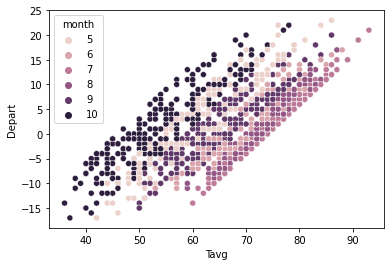

In [48]:
mask1 = ~df_obj['Tavg'].isna()
mask2 = ~df_obj['Depart'].isna()

sns.scatterplot(x='Tavg', y='Depart', hue='month', data=weather.loc[mask1 & mask2, :])
plt.show()

There appears to be some linear relation, but for different month we get different results, hence it would be better to fill missing data using the following strategy. First, if ohare data is missing, we can use midway data to fill it and vise versa. If both are missing, we can choose a time window and fill in the median value within that time window

In [49]:
def fill_na_for_numeric(data, feature, window_size):
    temp = data[feature].copy()
    is_missing = temp.isna()
    for i in range(0, data.shape[0]):
        if is_missing[i]:
            if data['Station'].values[i] ==1 and i+1<data.shape[0] and (not is_missing.values[i+1]):
                temp.values[i] = temp.values[i+1]
            elif data['Station'].values[i]==2 and i-1>=0 and (not is_missing.values[i-1]):
                temp.values[i] = temp.values[i-1]
            else:
                start_idx = min(max(0, i-window_size//2), data.shape[0]-window_size)
                record = []
                for j in range(start_idx, start_idx+window_size):
                    if not is_missing.values[j]:
                        record.append(temp.values[j])
                if record:
                    temp.values[i] = np.median(np.array(record))
                else:
                    temp.values[i] = np.median(temp.values)
    return temp                
                    
            

In [50]:
for col in df_obj.columns:
    weather[col] = fill_na_for_numeric(weather, col, 16)

In [51]:
weather.isna().sum().sort_values(ascending=False)

Station                 0
Tmax                    0
month                   0
year                    0
datetime                0
avg_wind_speed          0
wind_direction          0
wind_speed              0
sealevel_pressure       0
station_pressure        0
water_equiv_snowfall    0
weather_phenomena       0
Sunset                  0
Sunrise                 0
Cool                    0
Heat                    0
WetBulb                 0
DewPoint                0
Depart                  0
Tavg                    0
Tmin                    0
day                     0
dtype: int64

Transform wind_direction into degrees, then generate cos and sin of the angle

In [52]:
weather['wind_direction'] = weather['wind_direction']*10

In [53]:
weather['wind_direction_cos'] = np.cos(2*np.pi*weather['wind_direction']/360)
weather['wind_direction_sin'] = np.sin(2*np.pi*weather['wind_direction']/360)

Generate one-hot feature for each weather_phenomena code 

In [54]:
weather_code_feature = {}
for s in weather_code:
    weather_code_feature[s] = np.array([0]*weather.shape[0])

In [55]:
split = weather['weather_phenomena'].str.split()
for i in range(0,weather.shape[0]):
    for s in split.values[i]:
        weather_code_feature[s][i] = 1        

In [56]:
for s in weather_code_feature:
    weather[s] = weather_code_feature[s]

In [57]:
weather.head()

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,weather_phenomena,water_equiv_snowfall,station_pressure,sealevel_pressure,wind_speed,wind_direction,avg_wind_speed,datetime,year,month,day,wind_direction_cos,wind_direction_sin,FC,TS,GR,RA,DZ,SN,SG,GS,IC,FG,BR,UP,HZ,FU,VA,DU,DS,PO,SS,PY,SQ,SH,FZ,MI,PR,BC,BL,VC,FC+,FC-,TS+,TS-,GR+,GR-,RA+,RA-,DZ+,DZ-,SN+,SN-,SG+,SG-,GS+,GS-,IC+,IC-,FG+,FG-,BR+,BR-,UP+,UP-,HZ+,HZ-,FU+,FU-,VA+,VA-,DU+,DU-,DS+,DS-,PO+,PO-,SS+,SS-,PY+,PY-,SQ+,SQ-,SH+,SH-,FZ+,FZ-,MI+,MI-,PR+,PR-,BC+,BC-,BL+,BL-,VC+,VC-,MD
0,1,83,50,67.0,14.0,51,56.0,0.0,2.0,0448,1849,MD,0.0,29.10,29.82,1.7,270,9.2,2007-05-01,2007,5,1,-1.836970e-16,-1.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2,84,52,68.0,14.0,51,57.0,0.0,3.0,0448,1849,MD,0.0,29.18,29.82,2.7,250,9.6,2007-05-01,2007,5,1,-3.420201e-01,-0.939693,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1,59,42,51.0,-3.0,42,47.0,14.0,0.0,0447,1850,BR,0.0,29.38,30.09,13.0,40,13.4,2007-05-02,2007,5,2,7.660444e-01,0.642788,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2,60,43,52.0,-3.0,42,47.0,13.0,0.0,0447,1850,BR HZ,0.0,29.44,30.08,13.3,20,13.4,2007-05-02,2007,5,2,9.396926e-01,0.342020,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,66,46,56.0,2.0,40,48.0,9.0,0.0,0446,1851,HZ,0.0,29.39,30.12,11.7,70,11.9,2007-05-03,2007,5,3,3.420201e-01,0.939693,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [58]:
weather.isna().sum().sort_values(ascending=False)

Station    0
IC-        0
VA+        0
FU-        0
FU+        0
          ..
FG         0
IC         0
GS         0
SG         0
MD         0
Length: 109, dtype: int64

For many of the features, the corresponding column is actually constant, so we need to drop those columns

In [59]:
weather.describe()

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,water_equiv_snowfall,station_pressure,sealevel_pressure,wind_speed,wind_direction,avg_wind_speed,year,month,day,wind_direction_cos,wind_direction_sin,FC,TS,GR,RA,DZ,SN,SG,GS,IC,FG,BR,UP,HZ,FU,VA,DU,DS,PO,SS,PY,SQ,SH,FZ,MI,PR,BC,BL,VC,FC+,FC-,TS+,TS-,GR+,GR-,RA+,RA-,DZ+,DZ-,SN+,SN-,SG+,SG-,GS+,GS-,IC+,IC-,FG+,FG-,BR+,BR-,UP+,UP-,HZ+,HZ-,FU+,FU-,VA+,VA-,DU+,DU-,DS+,DS-,PO+,PO-,SS+,SS-,PY+,PY-,SQ+,SQ-,SH+,SH-,FZ+,FZ-,MI+,MI-,PR+,PR-,BC+,BC-,BL+,BL-,VC+,VC-,MD
count,2944.000000,2944.000000,2944.000000,2944.000000,2944.000000,2944.000000,2944.000000,2944.000000,2944.000000,2944.000000,2944.000000,2944.000000,2944.000000,2944.000000,2944.000000,2944.000000,2944.000000,2944.000000,2.944000e+03,2944.000000,2944.0,2944.000000,2944.00000,2944.000000,2944.000000,2944.000000,2944.0,2944.0,2944.0,2944.000000,2944.000000,2944.0,2944.000000,2944.000000,2944.0,2944.0,2944.0,2944.0,2944.0,2944.0,2944.000000,2944.0,2944.0,2944.000000,2944.0,2944.000000,2944.0,2944.000000,2944.0,2944.0,2944.0,2944.0,2944.0,2944.0,2944.0,2944.0,2944.0,2944.0,2944.0,2944.0,2944.0,2944.0,2944.0,2944.0,2944.0,2944.0,2944.000000,2944.0,2944.0,2944.0,2944.0,2944.0,2944.0,2944.0,2944.0,2944.0,2944.0,2944.0,2944.0,2944.0,2944.0,2944.0,2944.0,2944.0,2944.0,2944.0,2944.0,2944.0,2944.0,2944.0,2944.0,2944.0,2944.0,2944.0,2944.0,2944.0,2944.0,2944.0,2944.0,2944.0,2944.0,2944.0,2944.0,2944.0,2944.000000
mean,1.500000,76.166101,57.810462,67.223505,1.954484,53.457880,59.319293,3.417799,5.641304,0.131240,29.284429,29.968274,6.960666,174.949049,8.579076,2010.500000,7.500000,15.836957,-4.518518e-02,-0.057194,0.0,0.128397,0.00034,0.389946,0.047554,0.002717,0.0,0.0,0.0,0.014266,0.292459,0.0,0.099864,0.003397,0.0,0.0,0.0,0.0,0.0,0.0,0.001019,0.0,0.0,0.001019,0.0,0.002038,0.0,0.008492,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009171,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.487092
std,0.500085,11.461970,10.381939,10.550252,6.839947,10.675181,9.283540,5.955153,6.104849,0.393208,0.158450,0.158487,3.587527,100.636088,3.146201,2.291677,1.710236,8.855731,7.087664e-01,0.701908,0.0,0.334588,0.01843,0.487821,0.212858,0.052067,0.0,0.0,0.0,0.118607,0.454969,0.0,0.299870,0.058192,0.0,0.0,0.0,0.0,0.0,0.0,0.031911,0.0,0.0,0.031911,0.0,0.045106,0.0,0.091775,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.095342,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.499918
min,1.000000,41.000000,29.000000,36.000000,-17.000000,22.000000,32.000000,0.000000,0.000000,0.000000,28.550000,29.230000,0.100000,10.000000,1.700000,2007.000000,5.000000,1.000000,-1.000000e+00,-1.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
25%,1.000000,69.000000,50.000000,60.000000,-3.000000,46.000000,53.000000,0.000000,0.000000,0.000000,29.190000,29.870000,4.300000,70.000000,6.300000,2008.750000,6.000000,8.000000,-7.660444e-01,-0.766044,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
50%,1.500000,78.000000,59.000000,69.000000,2.000000,54.000000,61.000000,0.000000,4.000000,0.000000,29.2800

drop columns that are of constant value

In [60]:
for feature in weather.describe().columns:
    if weather[feature].max()==weather[feature].min():
        weather.drop(columns=[feature], inplace=True)
    

In [61]:
weather.head()

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,weather_phenomena,water_equiv_snowfall,station_pressure,sealevel_pressure,wind_speed,wind_direction,avg_wind_speed,datetime,year,month,day,wind_direction_cos,wind_direction_sin,TS,GR,RA,DZ,SN,FG,BR,HZ,FU,SQ,MI,BC,VC,FG+,MD
0,1,83,50,67.0,14.0,51,56.0,0.0,2.0,0448,1849,MD,0.0,29.10,29.82,1.7,270,9.2,2007-05-01,2007,5,1,-1.836970e-16,-1.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2,84,52,68.0,14.0,51,57.0,0.0,3.0,0448,1849,MD,0.0,29.18,29.82,2.7,250,9.6,2007-05-01,2007,5,1,-3.420201e-01,-0.939693,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1,59,42,51.0,-3.0,42,47.0,14.0,0.0,0447,1850,BR,0.0,29.38,30.09,13.0,40,13.4,2007-05-02,2007,5,2,7.660444e-01,0.642788,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,2,60,43,52.0,-3.0,42,47.0,13.0,0.0,0447,1850,BR HZ,0.0,29.44,30.08,13.3,20,13.4,2007-05-02,2007,5,2,9.396926e-01,0.342020,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
4,1,66,46,56.0,2.0,40,48.0,9.0,0.0,0446,1851,HZ,0.0,29.39,30.12,11.7,70,11.9,2007-05-03,2007,5,3,3.420201e-01,0.939693,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [62]:
weather.describe(include=['object'])

,Sunrise,Sunset,weather_phenomena
count,2944,2944,2944
unique,121,118,67
top,0416,1931,MD
freq,208,192,1434


In [69]:
weather['Sunrise'].value_counts().sort_values(ascending=False)

416    208
417    128
419     80
418     64
425     64
422     64
420     64
421     48
433     48
423     48
428     48
424     32
446     32
444     32
442     32
438     32
434     32
432     32
430     32
426     32
436     32
448     32
439     32
431     32
435     32
427     32
437     32
429     32
441     32
443     32
447     32
528     16
502     16
440     16
450     16
452     16
454     16
456     16
458     16
500     16
512     16
504     16
530     16
506     16
510     16
514     16
516     16
518     16
520     16
522     16
620     16
532     16
550     16
558     16
616     16
538     16
540     16
542     16
544     16
546     16
548     16
526     16
552     16
554     16
536     16
556     16
600     16
602     16
604     16
606     16
608     16
610     16
612     16
614     16
524     16
537     16
508     16
557     16
603     16
513     16
605     16
511     16
505     16
619     16
509     16
617     16
445     16
613     16
449     16
607     16
453     16

In [70]:
weather['Sunset'].value_counts().sort_values(ascending=False)

1931    192
1930    112
1929     96
1925     64
1923     64
1928     64
1927     64
1926     48
1920     48
1918     48
1916     48
1855     32
1919     32
1917     32
1851     32
1913     32
1903     32
1911     32
1859     32
1909     32
1907     32
1921     32
1915     32
1910     32
1904     32
1858     32
1849     32
1914     32
1902     32
1852     32
1856     32
1922     32
1924     32
1906     32
1908     32
1706     16
1824     16
1822     16
1814     16
1656     16
1658     16
1660     16
1704     16
1715     16
1712     16
1714     16
1720     16
1722     16
1724     16
1730     16
1734     16
1742     16
1711     16
1826     16
1842     16
1709     16
1860     16
1832     16
1834     16
1840     16
1746     16
1846     16
1848     16
1850     16
1854     16
1900     16
1707     16
1912     16
1647     16
1649     16
1651     16
1654     16
1657     16
1701     16
1703     16
1744     16
1829     16
1748     16
1845     16
1857     16
1901     16
1905     16
1807     16
1805

transform Sunrise and Sunset into numeric values, drop weather_phenomena

In [63]:
weather['Sunrise'] = pd.to_numeric(weather['Sunrise'])
weather['Sunset'] = pd.to_numeric(weather['Sunset'])

In [64]:
weather.drop(columns=['weather_phenomena'], inplace=True)

In [65]:
weather.isna().sum().sort_values(ascending=False)

Station                 0
FG                      0
wind_direction_cos      0
wind_direction_sin      0
TS                      0
GR                      0
RA                      0
DZ                      0
SN                      0
BR                      0
Tmax                    0
HZ                      0
FU                      0
SQ                      0
MI                      0
BC                      0
VC                      0
FG+                     0
day                     0
month                   0
year                    0
datetime                0
Tmin                    0
Tavg                    0
Depart                  0
DewPoint                0
WetBulb                 0
Heat                    0
Cool                    0
Sunrise                 0
Sunset                  0
water_equiv_snowfall    0
station_pressure        0
sealevel_pressure       0
wind_speed              0
wind_direction          0
avg_wind_speed          0
MD                      0
dtype: int64

In [66]:
weather.to_csv('cleaned_weather.csv')